In [3]:
!pip install "tensorflow-text>=2.11"
!pip install einops

In [4]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [6]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [7]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [8]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [9]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Termin\xc3\xa9 de trabajar a las seis.' b'Es en serio.'
 b'En una primera cita, es mejor mantenerse alejado de temas delicados.'
 b'\xc2\xbfCu\xc3\xa1nto es demasiado?'
 b'Dudo que nuestro nuevo jefe vaya a ser peor que el anterior.'], shape=(5,), dtype=string)

tf.Tensor(
[b'I finished work at six.' b"We're serious."
 b"On a first date, it's best to steer clear of touchy subjects."
 b'How much is too much?'
 b'I doubt that our new boss will be any worse than the old one.'], shape=(5,), dtype=string)


In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [13]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [15]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [16]:

context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 1678, 6, 326, 8, 33, 414, 4, 3], [2, 15, 14, 889, 4, 3],
 [2, 14, 23, 403, 1095, 19, 15, 115, 1, 1, 6, 4332, 1, 4, 3]]>

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] termine de trabajar a las seis . [END]'

Text(0.5, 1.0, 'Mask')

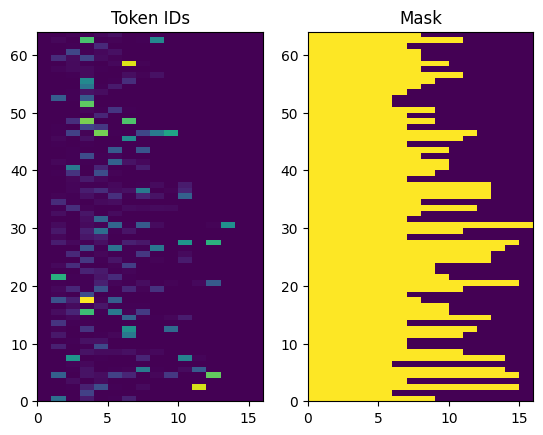

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2   7 242   9  62 963 293   4   3   0]

[  2   5 286 579  80 320   4   0   0   0]
[  5 286 579  80 320   4   3   0   0   0]


In [23]:
UNITS = 256

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


In [26]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [27]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 19, 256)
Attention result, shape (batch, t, units): (64, 19, 256)
Attention weights, shape (batch, t, s):    (64, 19, 22)


In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ], dtype=float32)

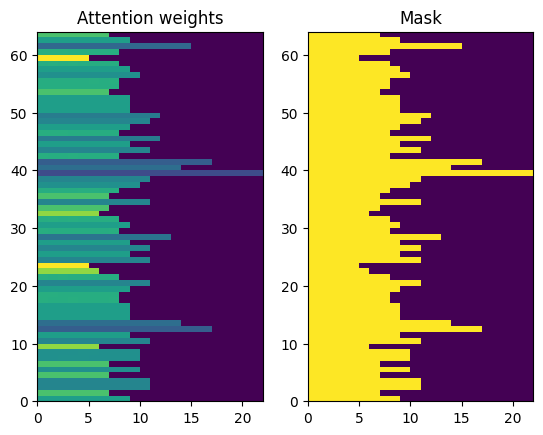

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [30]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [31]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [32]:
decoder = Decoder(target_text_processor, UNITS)

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 19)
logits shape shape: (batch, target_vocabulary_size) (64, 19, 5000)


In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'agrees veterinarian tough official expenses watered nature hadnt wednesday rings',
       b'january fiddle miles woken gas border gym opened afterwards rise',
       b'misunderstanding fish cut severely brief affairs described flying invited became'],
      dtype=object)

In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 19)
logits, shape: (batch, t, target_vocabulary_size) (64, 19, 5000)


### Train

In [40]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [42]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [43]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [44]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 14s 43ms/step - loss: 8.5211 - masked_acc: 8.8028e-05 - masked_loss: 8.5211


{'loss': 8.521143913269043,
 'masked_acc': 8.802816591924056e-05,
 'masked_loss': 8.521143913269043}

In [43]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 39s 216ms/step - loss: 4.9842 - masked_acc: 0.2685 - masked_loss: 4.9842 - val_loss: 4.0882 - val_masked_acc: 0.3563 - val_masked_loss: 4.0882
Epoch 2/100
100/100 [==============================] - 9s 94ms/step - loss: 3.6790 - masked_acc: 0.4093 - masked_loss: 3.6790 - val_loss: 3.2991 - val_masked_acc: 0.4437 - val_masked_loss: 3.2991
Epoch 3/100
100/100 [==============================] - 7s 66ms/step - loss: 3.0982 - masked_acc: 0.4828 - masked_loss: 3.0982 - val_loss: 2.8717 - val_masked_acc: 0.5147 - val_masked_loss: 2.8717
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 2.6882 - masked_acc: 0.5404 - masked_loss: 2.6882 - val_loss: 2.5513 - val_masked_acc: 0.5614 - val_masked_loss: 2.5513
Epoch 5/100
100/100 [==============================] - 7s 73ms/step - loss: 2.3890 - masked_acc: 0.5834 - masked_loss: 2.3890 - val_loss: 2.1829 - val_masked_acc: 0.6051 - val_masked_loss: 2.1829
Epoch 6/100
100/10

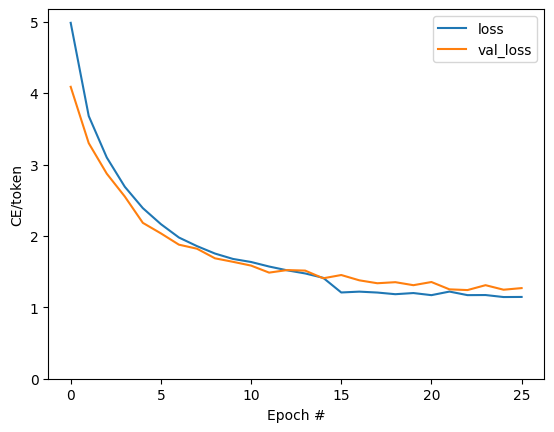

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

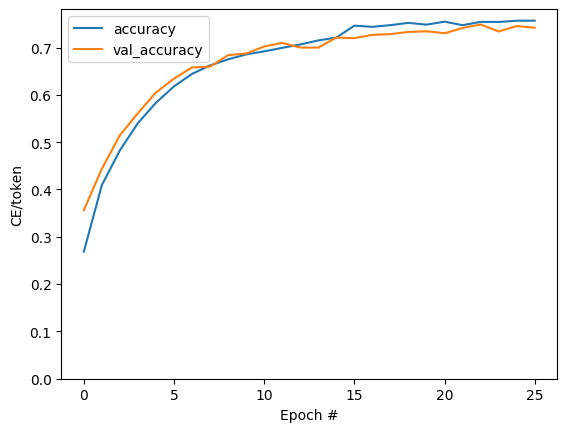

In [45]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [46]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [47]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is still at home ? '

In [48]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-48-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-48-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


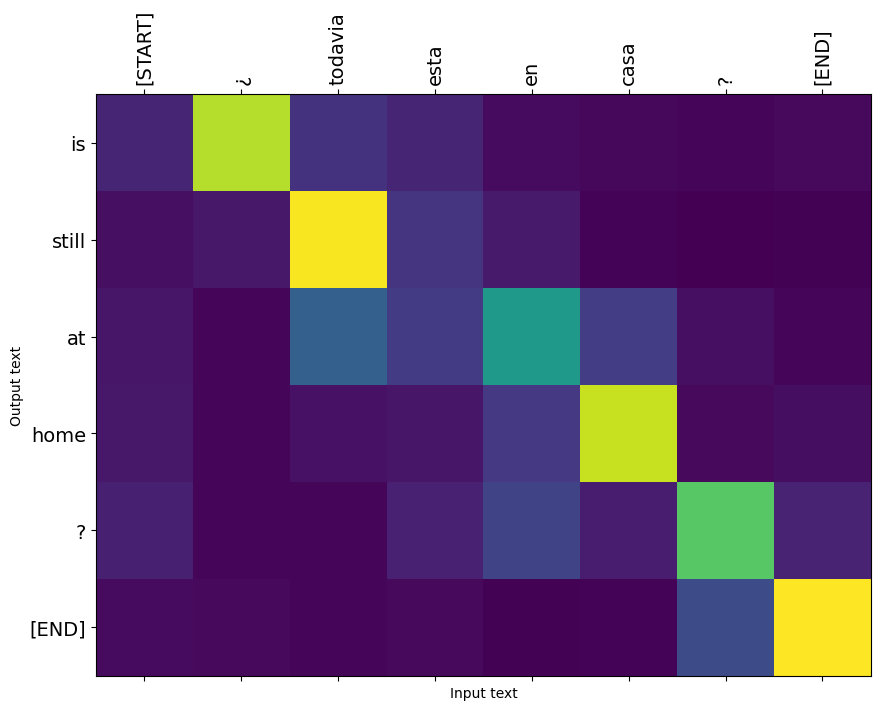

In [49]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

<ipython-input-48-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-48-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 246 ms, sys: 8.92 ms, total: 255 ms
Wall time: 252 ms


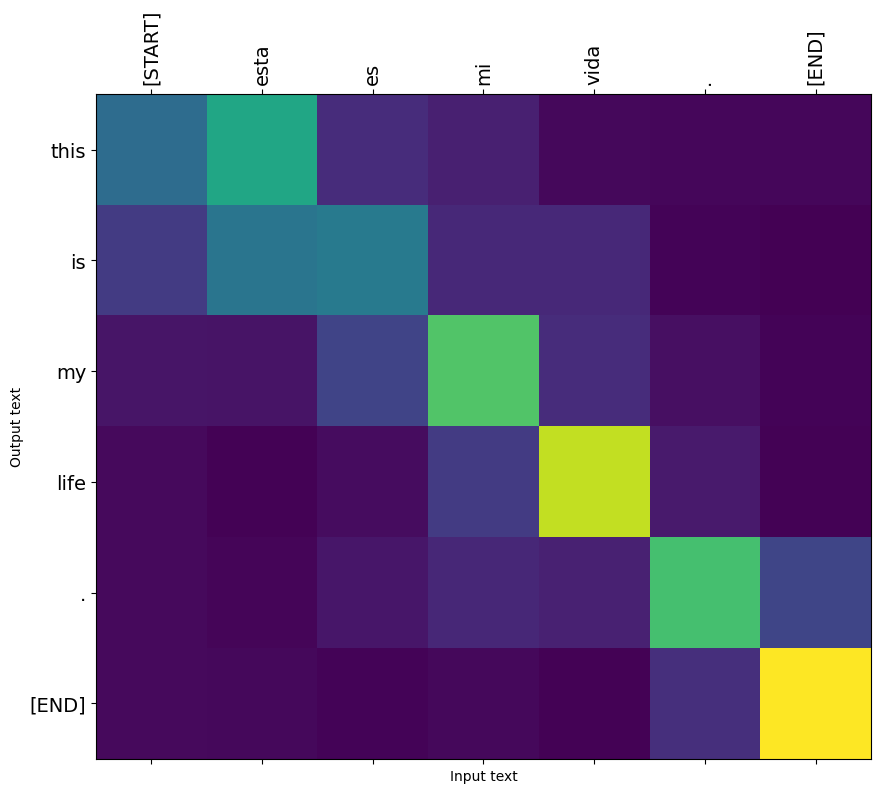

In [50]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

<ipython-input-48-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-48-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 256 ms, sys: 4.13 ms, total: 260 ms
Wall time: 256 ms


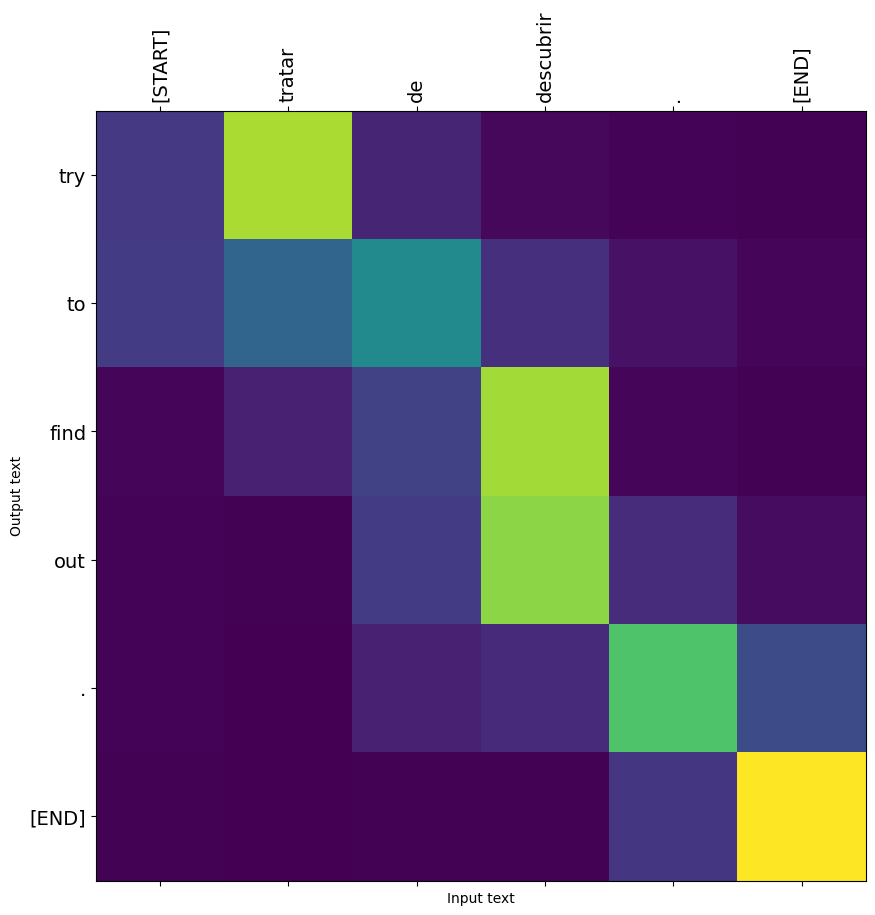

In [51]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')

In [52]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


<ipython-input-48-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-48-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


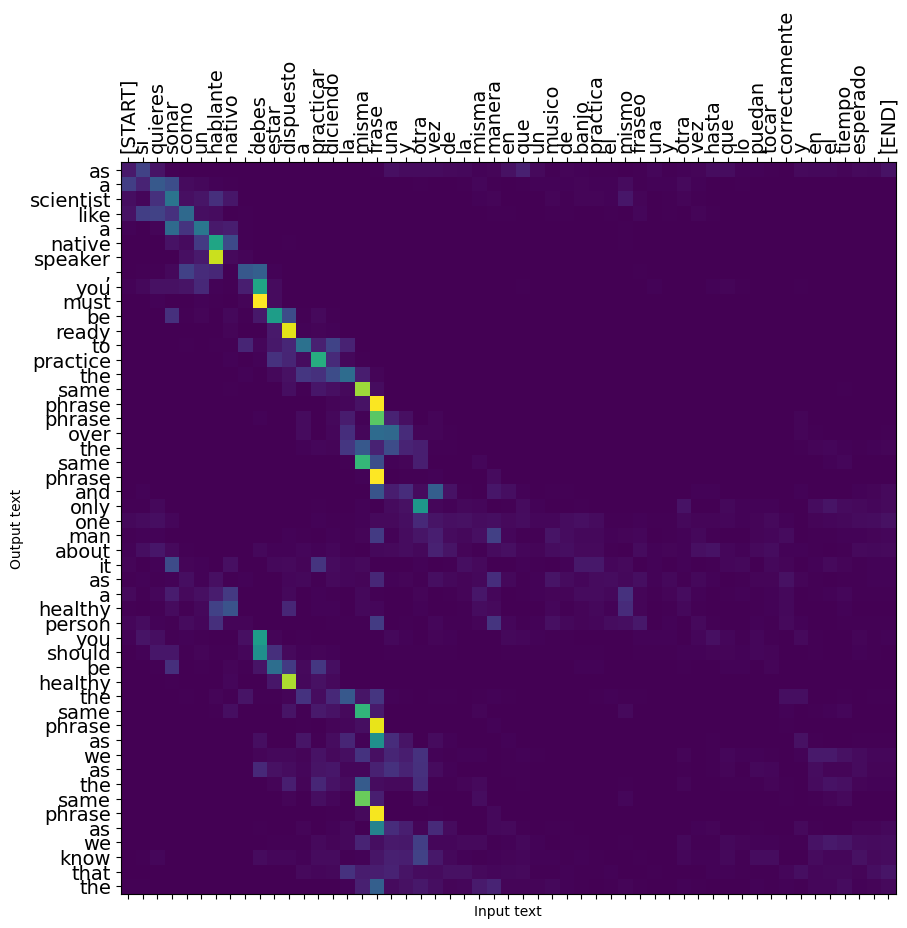

In [53]:
model.plot_attention(long_text)

In [46]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [55]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its very cold here . 
this is my life . 
his room is a mess . 

CPU times: user 1.08 s, sys: 13.9 ms, total: 1.09 s
Wall time: 1.09 s


In [56]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 285 ms, sys: 5.9 ms, total: 291 ms
Wall time: 289 ms


In [57]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [58]:
export = Export(model)

In [59]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 15s, sys: 1.53 s, total: 1min 17s
Wall time: 1min 17s


In [60]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a mess .                                            

CPU times: user 135 ms, sys: 8.39 ms, total: 143 ms
Wall time: 141 ms


In [61]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 32s, sys: 1.74 s, total: 1min 34s
Wall time: 1min 34s


In [62]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 1min 5s, sys: 1.35 s, total: 1min 7s
Wall time: 1min 6s


In [63]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a mess .                                            

CPU times: user 131 ms, sys: 9.1 ms, total: 140 ms
Wall time: 139 ms


This version of the code can be quite a bit more efficient:

In [64]:
#@title
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [65]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 287 ms, sys: 2.87 ms, total: 290 ms
Wall time: 290 ms


In [66]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [67]:
export = Export(model)

In [68]:
%%time
_ = export.translate(inputs)

CPU times: user 5.22 s, sys: 21.7 ms, total: 5.25 s
Wall time: 5.14 s


In [69]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 27.9 ms, sys: 5.07 ms, total: 32.9 ms
Wall time: 31.3 ms


In [70]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

CPU times: user 29.4 s, sys: 207 ms, total: 29.6 s
Wall time: 29.7 s


In [47]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 13.3 s, sys: 416 ms, total: 13.8 s
Wall time: 16.5 s


In [48]:
_ = reloaded.translate(tf.constant(inputs)) #warmup
results = reloaded.translate(tf.constant(inputs))
result[0].numpy().decode()

'agrees veterinarian tough official expenses watered nature hadnt wednesday rings'

In [49]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a mess . 

CPU times: user 33.1 ms, sys: 2.79 ms, total: 35.9 ms
Wall time: 43.4 ms


In [50]:
val_raw

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [51]:
import tensorflow as tf

# Your BatchDataset object
batch_dataset = val_raw

input_text = []
output_text = []

# Iterate through batches
for string_tensor_1, string_tensor_2 in batch_dataset:
    # Convert TensorFlow tensors to numpy arrays for easy viewing
    strings_1 = string_tensor_1.numpy()
    strings_2 = string_tensor_2.numpy()

    # Print or process individual strings in each batch
    for s1, s2 in zip(strings_1, strings_2):
        input_text.append(s1.decode('utf-8'))
        output_text.append(s2.decode('utf-8'))



In [52]:
_ = reloaded.translate(tf.constant(input_text)) #warmup
results = reloaded.translate(tf.constant(input_text))
results[0].numpy().decode()

'tom is [UNK] .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                '

In [53]:
model_output = []
for i in range(len(input_text)):
  model_output.append(results[i].numpy().decode())

## Metrics

In [54]:
print(output_text[0], model_output[0])
print(len(output_text), len(model_output))

Tom is breathing. tom is [UNK] .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
23721 23721


In [55]:
print(output_text[586], model_output[586])

Tom isn't concentrating, is he? tom isnt babbling , isnt he ?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


In [56]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu1_score(expected_output, model_output):
    references = [[expected.split()] for expected in expected_output]
    hypotheses = [model.split() for model in model_output]

    bleu1_score = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    return bleu1_score

# Example input
expected_output = output_text
model_output = model_output

bleu1_score = calculate_bleu1_score(expected_output, model_output)
print("BLEU-1 Score:", bleu1_score)

BLEU-1 Score: 0.35592053041975996


In [57]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=4fd19e51d39edff1a473c1ad59f9afa99d13d41e372608305a6a21a5ce26d52c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [58]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(expected_output, model_output):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = {
        'rouge1': [],
        'rouge2': [],
        'rougeL': []
    }

    for expected, model in zip(expected_output, model_output):
        scores = scorer.score(expected, model)
        for metric in scores:
            rouge_scores[metric].append(scores[metric].fmeasure)

    avg_rouge_scores = {metric: sum(scores) / len(scores) for metric, scores in rouge_scores.items()}
    return avg_rouge_scores

# Example input
expected_output = output_text
model_output = model_output

rouge_scores = calculate_rouge_scores(expected_output, model_output)
for metric, score in rouge_scores.items():
    print(f"ROUGE-{metric}: {score}")

ROUGE-rouge1: 0.6524384581872881
ROUGE-rouge2: 0.43745450532736435
ROUGE-rougeL: 0.6424786284023407


In [59]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 1.5 MB/s eta 0:00:00


In [60]:
import nltk

def wer(reference, candidate):
    reference = reference.lower().split()
    candidate = candidate.lower().split()

    # Calculate Levenshtein distance
    distance = nltk.edit_distance(reference, candidate)

    # Calculate Word Error Rate
    wer = distance / len(reference) * 100
    return wer

# Example reference and candidate lists
expected_output = output_text
model_output = model_output

wer_scores = []
for reference, candidate in zip(expected_output, model_output):
    wer_score = wer(reference, candidate)
    wer_scores.append(wer_score)

average_wer = sum(wer_scores) / len(wer_scores)
print("Average Word Error Rate (WER):", average_wer)


Average Word Error Rate (WER): 72.55613447290959
